# Molecular Dynamics

## Objectives

* Understand the basics of molecular dynamics
* Simulate systems with different conditions.


In molecular dynamics the motion of a set of atoms is obtained by solving the Newton's equation of motion, which need as input the inter atomic interactions. We demonstrate the basic physical formulation for a Lennard-Jones model for a gas and provide a Python implementation of the molecular dynamics algorithm. This Python implementation is too slow for any practical application. 

Before we start, I want to point out that here I will be assuming that particles are classical. In real life, THEY ARE NOT and we should need to solve the Schrödinger equation. Something that can be done by following some of the methods presented in this class. This happens to be quite expensive and we need to rely on approximations. The use of classical physics is one of them, where we need to define before hand the inter atomic potential (which in many cases capture the correct physics, What we do in "actual applications" is that we parametrize the iteratomic interactions. This means that we are able to build a function $V(x_1,x_2,... x_N)$ that depends on the atomic positions and provide a measure of the potential energy for that configuration.

Whatever is the form of the potential, it depends on all atomic positions, we can expand then the potential as contributions of different type, only pair interactions, three-particle interactions, or even many-particle interactions. The form of the potential can be then very complicated, depending on the different effects we want to capture. Here, we will primarily use simple models, since the statistical and thermal effects we are interested in do not depend strongly on the details of the system. One of the simplest models for atom-atom interactions is a representation of the interactions between nobel-gas atoms, such as between two Argon atoms. The so called Van der Waals potential:
$$
V(r_{ij}) = 4 \epsilon \left( \left( \frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right)
$$

Where the force over each atom can be easily obtained by using that
$$
\vec{F}_i = \nabla_i V(r_{ij})
$$



In [1]:
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from PIL import Image
import glob
#import moviepy.editor as mp
from datetime import datetime
import time
# Import libraries for system operations
import os.path
from os import path
import shutil

%matplotlib inline

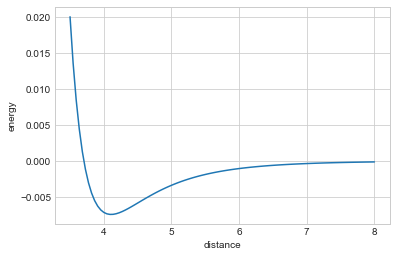

In [2]:
def ljp(r, epsilon, sigma):
    
    return 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) \
    - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)
    
r = np.linspace(3.5, 8, 100)
plt.plot(r, ljp(r, 0.0103, 3.3))
plt.xlabel('distance')
plt.ylabel('energy')
plt.show()

In [3]:
class Atoms():
    def __init__(self, r=np.asarray([0.0, 0.0]), rv=np.asarray([0.0, 0.0]), ra=np.asarray([0.0, 0.0])):
        self.r  = r
        self.rv = rv
        self.ra = ra

class Prop():
    def __init__(self, val=0.0, sum1=0.0, sum2=0.0 ):
        self.val=val
        self.sum1=sum1
        self.sum2=sum2

Before we start looking into the dynamical equations, there are two ingredients we need to know. We need to know the initial conditions (where the particles are located and what are the initial velocities of the partcles) at the beginning of the simulation and what are the boundary conditions.

For the initial conditions, we need to be careful as the potential increases very quickly over the interatomic distance, if the atoms are too close, the energy is very large and the forces HUGE. IN this case, I am going to assume that particles are located in a cubic lattice. 

In [4]:
def VRand(p):
    s: float
        
    s = 2. * math.pi * np.random.rand()
    p[0] = math.cos(s)
    p[1] = math.sin(s)
    return p


# Periodic Boundary conditions for a single particle
# it assumes that it is 2D and that the box is centered as -a/2, a/2
def VWrapAll(v):
    if v[0] >= 0.5 * region[0]:
        v[0] -= region[0]
    elif v[0] < -0.5 * region[0]:
        v[0] += region[0]

    if v[1] >= 0.5 * region[1]:
        v[1] -= region[1]
    elif v[1] < -0.5 * region[1]:
        v[1] += region[1]


# This function updates coordinates taking care of periodic boundaries for all particles
def ApplyBoundaryCond():
    for n in range(natoms):
        VWrapAll(mol[n].r)

# INITIALIZE COORDINATES.
# Here a simple square lattice (with the option of unequal edge lenghts) is used,
# so that each cell contains just one atom and the system is centered about the origin

def InitCoords():

    c = np.asarray([0.0, 0.0]) # Coords
    gap = np.divide(region, unitCell)
    n = 0
    for ny in range(0, int(unitCell[1])):
        for nx in range(0, int(unitCell[0])):

            mol[n].r = np.add(np.multiply(np.asarray([nx+0.5, ny+0.5]), gap), np.multiply(-0.5, region))
            n = n+1




In [5]:
# INITIALIZE VELOCITIES.
# The initial velocities are set to fixed magnitude (velMag)
# that depends on the temperature. After assigning random velocity directions
# the velocoties are adjusted to ensure that the center of mass is stationary.
# The function vRand serves as a source of uniformly distribuited radnom unit vectors.

# remember that N_degree* K * T/2 = \sum m V_i^2/2

def InitVels():

    global vSum
    vSum = np.zeros(vSum.shape)

    for n in range(natoms):
        VRand(mol[n].rv)
        # needed velMag coming fro
        mol[n].rv = np.multiply(mol[n].rv, velMag)
        vSum = np.add(vSum, mol[n].rv)


# velocities should not have a drift. They have to add to zero in average

    for n in range(natoms):
        mol[n].rv = np.add(mol[n].rv, np.multiply((- 1.0 / natoms),  vSum))


# INITIALIZE ACCELERATIONS.
# The accelerations are initilized to zero
def InitAccels():
    for n in range(natoms):
        mol[n].ra = np.zeros(mol[n].ra.shape)

# Set parameters
def SetParams():

    global rCut
    global region
    global velMag # velocity magnitude

    rCut = math.pow(2., 1./6. * sigma)
    # Define the region
    region = np.multiply( 1./math.sqrt(density), unitCell)
    natoms = len(mol)
    #velocity magnitude depends on the temperature
    velMag = math.sqrt(NDIM * (1. -1. /natoms) * temperature)


             

In [6]:
# Setup Job
def SetupJob():

    global stepCount #  timestep counter 

    stepCount = 0
    InitCoords()
    InitVels()
    InitAccels()
    AccumProps(0)


In [7]:
'''
ComputeForces
ComputeForces is responsible for the interaction computations, and the interactions occur between pairs of atoms.
The function implements the LJP, and calculates the accelerations and the forces for each pairs of atoms i and j
located at ri and rj.
rCut = Limiting separation cutoff (rc), and it is: rCut = math.pow(2., 1./6.)
This is just to avoid particles that are too far.. we just make a cutoff for the potential.
As r increases towards rCut, the force drops to 0.
Newton's third law inplies that fji = -fij, so each atom pair need only be examined once.
The amount of work is proportional to N^2.
'''

def ComputeForces():

    global virSum
    global uSum
    fcVal = 0 #  The force that atom j exerts on atom i

    # rCut: Rc
    rrCut = rCut*rCut
    for n in range(natoms):
        mol[n].ra = np.zeros(mol[n].ra.shape)
    uSum = 0.
    virSum = 0.

    n = 0
    for j1 in range(natoms-1):
        for j2 in range(j1+1, natoms):

            # Make DeltaRij: (sum of squared RJ1-RJ2)
            dr = np.subtract(mol[j1].r, mol[j2].r) # dr contains the delta between Rj1 and Rj2
            VWrapAll(dr) # toroidal function
            rr= (dr[0] * dr[0] + dr[1] * dr[1]) # dr2
            r= np.sqrt(rr) #dr

            # if dr2 < Rc^2
            if (rr < rrCut):
                rri = sigma / rr
                rri3 = rri*rri*rri

                # Forces calculation by Lennard-Jones potential (original from Rapaport)
                # fcVal = 48. * rri3 * (rri3 - 0.5) * rri
                # Forces calculated with the completed Lennard-Jones.
                fcVal = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)

                # Update the accelerations multiplying force for DeltaRij
                mol[j1].ra = np.add(mol[j1].ra, np.multiply(fcVal, dr))
                mol[j2].ra = np.add(mol[j2].ra, np.multiply(-fcVal, dr))

                # Lennard-Jones potential (original from Rapaport)
                # uSum += 4. * rri3 * (rri3 - 1.) +1.
                # The completed Lennard-Jones.
                uSum += 4 * epsilon * np.power(sigma/r, 12)/r - np.power(sigma/r, 6) # balanced

                # The virial theorem is a relation between the kinetic energy and the potential energy
                
                #  the virial theorem provides a general equation that relates the average over time of the 
                # total kinetic energy of a stable system of discrete particles, bound by potential forces,
                
                virSum += fcVal * rr


In [8]:
'''
INTEGRATION OF COORDINATES AND VELOCITIES.
Integration of Equation of Motion uses a simple numerical techniques: the leapfrog method.
The method has excellent energy conservation properties.
LeapfrogStep integrates the coordinates and velocities. It appears twice in the listing of
SingleStep, with the argument part determinating which portion of the two-step leapfrog process
is to be performed:
vix(t + h/2) = vix(t) + (h/2)aix(t)
rix(t + h) = rix(t) + hvix (t + h/2)
'''
def LeapfrogStep(part):

    if part == 1:
        for n in range(natoms):
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * delta_t, mol[n].ra))
            mol[n].r = np.add(mol[n].r, np.multiply(delta_t, mol[n].rv))

    else :
        for n in range(natoms):
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * delta_t, mol[n].ra))


In [9]:
# PROPERTIES MEASUREMENTS

def EvalProps():

    global vSum
    vvSum = 0.
    
    # vSum is the sum for vx, sum for vy, sum for vz
    
    vSum = np.zeros(vSum.shape)

    global kinEnergy
    global totEnergy
    global pressure


    for n in range(natoms):
        vSum=np.add(vSum, mol[n].rv)
        vv= (mol[n].rv[0] * mol[n].rv[0] + mol[n].rv[1] * mol[n].rv[1])
        vvSum += vv

    kinEnergy.val = (0.5 * vvSum) / natoms
    totEnergy.val = kinEnergy.val + (uSum / natoms)
    pressure.val = density * (vvSum + virSum) / (natoms * NDIM)


# AccumProps functions

def PropZero(v):
    v.sum1 = v.sum2 = 0.
    return v

def PropAccum(v):
    v.sum1 += v.val
    v.sum2 += v.val*v.val
    return v

def PropAvg(v, n):
    v.sum1 /= n
    v.sum2 = math.sqrt(max(v.sum2 / n - (v.sum1*v.sum1), 0.))
    return v


# AccumProps: collects results of the measurements and evaluates means and standard deviation
def AccumProps(icode):


    if icode == 0:
        PropZero(totEnergy)
        PropZero(kinEnergy)
        PropZero(pressure)
    if icode == 1:
        PropAccum(totEnergy)
        PropAccum(kinEnergy)
        PropAccum(pressure)
    if icode == 2:
        PropAvg(totEnergy, stepAvg)
        PropAvg(kinEnergy, stepAvg)
        PropAvg(pressure, stepAvg)



In [10]:
# OUTPUT FUNCTIONS:

def plotAtomsCoor(mol, workdir, n):

    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt

    Time = timeNow
    Sigma_v = "{0:.4f}".format(vSum[0] / natoms)
    E = "{0:.4f}".format(totEnergy.sum1)
    Sigma_E = "{0:.4f}".format(totEnergy.sum2)
    Ek = "{0:.4f}".format(kinEnergy.sum1)
    Sigma_Ek = "{0:.4f}".format(kinEnergy.sum2)
    P_1 = "{0:.4f}".format(pressure.sum1)
    P_2 = "{0:.4f}".format(pressure.sum2)


    %matplotlib inline

    TileName = (workdir+'coo/'+str(n)+'.png')

    x = []
    y = []

    for n in range(len(mol)):
        x.append(mol[n].r[0])
        y.append(mol[n].r[1])

    mark_1 = int(len(mol)/2 + len(mol)/8)
    mark_2 = int(len(mol)/2 + len(mol)/8 + 1)

    plt.plot(x, y, 'o', color='blue')
    plt.plot(x[mark_1], y[mark_1], 'o', color='red')
    plt.plot(x[mark_2], y[mark_2], 'o', color='cyan')


    plt.title('timestep:'+"{0:.4f}".format(timeNow)+'; '+\
              '$\Sigma v$:'+Sigma_v+'; '+\
              'E:'+E+'; '+\
              '$\sigma E$:'+Sigma_E+';\n'+\
              'Ek:'+Ek+'; ' +\
              '$\sigma Ek$:'+Sigma_Ek+'; '+\
              'P.sum1:'+P_1+'; '+\
              'P.sum2:'+P_2+'; ', loc='left')

    plt.rcParams["figure.figsize"] = (200,3)
    plt.savefig(TileName, dpi=100)

def makeMov():
    # For more information about the use of the glob package with Python, and for the convertion from
    # gif to mp4 video formats see:
    #https://pythonprogramming.altervista.org/png-to-gif/
    #https://stackoverflow.com/questions/6773584/how-is-pythons-glob-glob-ordered
    #https://www.programiz.com/python-programming/datetime/current-time
    #https://stackoverflow.com/questions/40726502/python-convert-gif-to-videomp4


    t = time.localtime()
    current_time = time.strftime("%D:%H:%M:%S", t)
    current_time = current_time.replace('/','-')


    # Create the frames
    frames = []
    imgs = sorted(glob.glob('coo/*.png'), key=os.path.getmtime)
    for i in imgs:
        temp = Image.open(i)
        keep = temp.copy()
        frames.append(keep)
        temp.close()
    for i in imgs:
        os.remove(i)

    # Save into a GIF file that loops forever
    frames[0].save('coo/coordinates.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=30, loop=0)


    clip = mp.VideoFileClip("coo/coordinates.gif")
    clip.write_videofile("coo/"+"coordinates_"+current_time+".mp4")
    os.remove("coo/coordinates.gif")

def PrintSummary():

    print(stepCount, \
          "{0:.4f}".format(timeNow), \
          "{0:.4f}".format(vSum[0] / natoms) ,\
          "{0:.4f}".format(totEnergy.sum1),\
          "{0:.4f}".format(totEnergy.sum2), \
          "{0:.4f}".format(kinEnergy.sum1), \
          "{0:.4f}".format(kinEnergy.sum2),\
          "{0:.4f}".format(pressure.sum1),\
          "{0:.4f}".format(pressure.sum2))

    return (stepCount, \
          timeNow, \
          (vSum[0] / natoms) ,\
          totEnergy.sum1,\
          totEnergy.sum2, \
          kinEnergy.sum1, \
          kinEnergy.sum2,\
          pressure.sum1,\
          pressure.sum2)


def GraphOutput():

    ax = \
    df_systemParams.plot(x="timestep", y='$\Sigma v$', kind="line")
    df_systemParams.plot(x="timestep", y='E', kind="line", ax=ax, color="C1")
    df_systemParams.plot(x="timestep", y='$\sigma E$', kind="line", ax=ax, color="C2")
    df_systemParams.plot(x="timestep",  y='Ek', kind="line", ax=ax, color="C3")
    df_systemParams.plot(x="timestep", y='$\sigma Ek$', kind="line", ax=ax, color="C4")
    df_systemParams.plot(x="timestep", y='P_1', kind="line", ax=ax, color="C9")
    df_systemParams.plot(x="timestep", y='P_2', kind="line", ax=ax, color="C9")

    plt.show()
    plt.savefig('coo/ParametersPlot.jpg', dpi=300)



In [11]:
# HANDLING FUNCTION (SingleStep())
'''
SingleStep: Is the function that handles the processing for a single timestep, including:
1) the force evaluation
2) integration of the equation of motion,
3) adjustments required by periodic boundaries, and
4) property measurements
'''
def SingleStep():

    global stepCount #  timestep counter
    global timeNow

    stepCount +=1
    timeNow = stepCount * delta_t
    LeapfrogStep(1)
    ApplyBoundaryCond()
    ComputeForces() # 1) The force evaluation
    LeapfrogStep(2) # 2) Integration of coordinates and velocities
    EvalProps()
    AccumProps(1) # Accumulate properties

    if (stepCount % stepAvg == 0):
        AccumProps(2) # Calculate averages
        systemParams.append(PrintSummary())
        AccumProps(0) # Set to zero all the properties.

KeyboardInterrupt: 

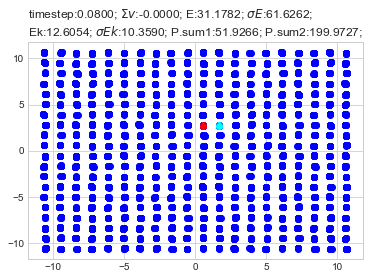

In [13]:
# PARAMETERS
mov = 1 # set mov=1 if you want make a video

# Set a working directory for all the png and videos
workdir = str(os.getcwd()+'/')

# If the /coo directory doesn't exist make it, else remove /coo (and its contents) and 
# create a new /coo directory.
if path.exists(str(workdir+'coo'))==False:
    os.makedirs(str(workdir+'coo'))
else:
    shutil.rmtree(str(workdir+'coo'))
    os.makedirs(str(workdir+'coo'))

# Load the input parameter file
#df_params = pd.read_csv('Rap_2_LJP.in', sep='\t', header=None, names=['parameter', 'value'])

NDIM = 2 # Two-Dimension setting
vSum = np.asarray([0.0, 0.0]) # velocity sum
kinEnergy =Prop(0.0, 0.0, 0.0) #Ek (and average)
totEnergy =Prop(0.0, 0.0, 0.0) #E (and average)
pressure  =Prop(0.0, 0.0, 0.0) #P (and average) 

systemParams = []

#IADD = 453806245
#IMUL = 314159269
#MASK = 2147483647
#SCALE = 0.4656612873e-9
#randSeedP = 17

delta_t=0.005
density=0.8
unitCell_x=20
unitCell_y=20
stepAvg=100
stepEquil=0
#stepLimit=500
stepLimit=50
temperature=1.
# LJP parameters:
epsilon =  1
sigma = 1

unitCell = np.asarray([unitCell_x, unitCell_y]) # initialize cell

mol = [Atoms(np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0])) for i in range(int(unitCell[0]*unitCell[1]))]


# Define the number of molecules
global natoms
natoms = len(mol)


# START THE MAIN LOOP
SetParams()
SetupJob()
moreCycles = 1

n = 0
while moreCycles:
    SingleStep()
    if mov==1:
        plotAtomsCoor(mol, workdir, n) # Make a graph of the coordinates
    n += 1
    if stepCount >= stepLimit:
        moreCycles = 0

columns = ['timestep','timeNow', '$\Sigma v$', 'E', '$\sigma E$', 'Ek', '$\sigma Ek$', 'P_1', 'P_2']
df_systemParams = pd.DataFrame(systemParams, columns=columns)

# Make a video
if mov==1:
    makeMov()

GraphOutput()
